In [15]:
import tensorflow as tf
import numpy as np

import random, math, itertools
from collections import defaultdict, deque, Counter

import matplotlib.pylab as plt

%load_ext autoreload
%autoreload 2

In [2]:
m = 512 # code weight matrix dimension
n = 1024 # visit weight matrix dimension
code_len = 5

max_iter = 2000
max_iter_progress_report = 100

batch_size = 10

In [37]:
import data.coril as coril
import data.mimic as mimic
import data.vectorize as vectorize
from med2vec import med2vec

In [34]:
observations, dictionary, reverse_dictionary = coril.read_visits("test_data/mimic_demo.seq")
mimic.read_translator("test_dicts/mimic_icd9.csv")
code_dim = len(dictionary)
print("Data contains {} observations with {} different codes".format(len(observations), C))

Data contains 14 observations with 259 different codes


In [46]:
input_output_generator = vectorize.random_input_output_generator(observations, dictionary, window_size=1, sample=3)
code_weight, visit_weight = med2vec(input_output_generator,
                                    code_dim=code_dim,
                                    max_iter=max_iter)

-0.00451277


In [35]:
med2vec = tf.Graph()

with med2vec.as_default():
    
    # x represents a number of visits visits
    x = tf.placeholder(tf.float32, shape=(None, C))
    
    # y represents the context of a visit e.g., a label in another visit
    y = tf.placeholder(tf.float32, shape=(None, C))
    
    # the bias term for the code representation
    b_c = tf.Variable(tf.zeros([m]), name="b_c")
    
    # the code vector
    # each code 1..C, is represented by a vector of m elements
    # initialized with a small random number
    W_c = tf.Variable(tf.random_uniform([C, m], -0.01, 0.01), name="W_c")
    
    # the intermidiate visit representation is given by the
    # sum of the visits (each row of x) multiplied by the code vector 
    # which is a column of W_c
    #u_t = tf.nn.relu(tf.matmul(x, W_c) + b_c, name="u_t")
    u_t = tf.nn.relu_layer(x, W_c, b_c)
    
    # the bias term for the visit representation
    b_v = tf.Variable(tf.zeros([n]))
    
    # the visit weight matrix.  
    W_v = tf.Variable(tf.random_uniform([m, n], -0.01, 0.01))
        
    #v_t = tf.nn.relu(tf.matmul(u_t, W_v) + b_v, name="v_t")
    v_t = tf.nn.relu_layer(u_t, W_v, b_v)
    
    b_s = tf.Variable(tf.zeros([C]))
    W_s = tf.Variable(tf.random_uniform([n, C], -0.01, 0.01))
    
    y_t = tf.matmul(v_t, W_s) + b_s
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_t, labels=y))
    reg_loss = loss + (0.001 * (tf.nn.l2_loss(W_v) + tf.nn.l2_loss(W_c) + tf.nn.l2_loss(W_s)))
   
    global_step = tf.Variable(0)
    start_learning_rate = 0.5
    learning_rate = tf.train.exponential_decay(0.5, global_step, 100000, 0.96, staircase=True)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(reg_loss, global_step=global_step)
    init = tf.global_variables_initializer()
    
    
with tf.Session(graph=med2vec) as session:

    init.run()
    loss_values = []
    tmp_loss = []
    
    #vec_obs = vectorize.simple_input_output_generator(
    #    observations, dictionary, max_skip_ahead=5, random_output=False)
    vec_obs = vectorize.random_input_output_generator(
        observations, dictionary, window_size=1, sample=3)
    vec_cycle = itertools.cycle(vec_obs)
    for i in range(max_iter):
        x_data, y_data = vectorize.generate_batch(vec_cycle, batch_size=batch_size)
        _, loss_value,  = session.run([optimizer, loss], feed_dict= {x: x_data, y: y_data})

        tmp_loss.append(loss_value)
        if i % max_iter_progress_report == 0:
            print(max_iter_progress_report, " iterations", np.mean(tmp_loss))
            loss_values.append(np.mean(tmp_loss))
            tmp_loss = []
        
    W_c_val = W_c.eval()
    W_v_val = W_v.eval()
    b_c_val = b_c.eval()

100  iterations 5.55681
100  iterations 5.1486
100  iterations 4.59105
100  iterations 4.34762
100  iterations 3.99973
100  iterations 3.57796
100  iterations 3.12495
100  iterations 2.66029
100  iterations 2.35496
100  iterations 2.07874
100  iterations 1.92376
100  iterations 1.89491
100  iterations 1.84039
100  iterations 1.80346
100  iterations 1.76527
100  iterations 1.77404
100  iterations 1.7641
100  iterations 1.73778
100  iterations 1.71561
100  iterations 1.73005


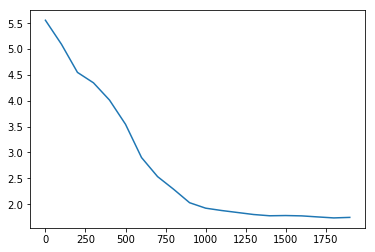

In [32]:
plt.plot(range(0, max_iter, max_iter_progress_report), loss_values)
plt.show()

In [13]:
from data import chain_dict
translator = chain_dict(reverse_dictionary, code_dictionary)

In [27]:
list(map(lambda f: mimic_trans[f], np.argsort(np.maximum(code_weight, 0)[:,100])[::-1][:10]))

['Hypertension NOS',
 '5185',
 'Cardiac tamponade',
 'Acute kidney failure NOS',
 'Hepatorenal syndrome',
 '2766',
 'Mal neo stomach cardia',
 'Int inf clstrdium dfcile',
 'Acute cholecystitis',
 'Perforation gallbladder']

In [30]:
W_c_val[:,1].shape

(259,)

In [2]:
from med2vec import med2vec
import data.io
import data.vectorize as vectorize

m = 1024  # code weight matrix dimension
n = 2048  # visit weight matrix dimension
code_len = 2
transform = lambda code: code[:code_len]
transform = None

max_iter = 500
max_iter_progress_report = 100

batch_size = 128

observations, dictionary, reverse_dictionary = data.io.read_visits(
    "test_data/mimic_demo.seq")
# observations, dictionary, reverse_dictionary = data.io.read_visits(
#    "/mnt/veracrypt1/val/slv_events.seq", transform=transform)
code_dim = len(dictionary)
print("Data contains {} observations with {} different codes".format(
        len(observations), code_dim))

input_output_generator = vectorize.random_input_output_generator(
    observations, dictionary, window_size=1, sample=3)
m2v = med2vec(input_output_generator,
              code_dim=code_dim,
              max_iter=max_iter,
              code_rep_dim=m,
              visit_rep_dim=n,
              l2_reg=0.0)

Data contains 14 observations with 259 different codes
INFO:tensorflow:Scale of 0 disables regularizer.


ValueError: Rank mismatch: Rank of labels (received 2) should equal rank of logits minus 1 (received 2).

In [9]:
observation = observations[1][0]
print(observation)
visit = vectorize._vectorize_visit(observation, dictionary)
print(m2v.transform(visit))

{'311', '2859', '99592', '0389', '0414', '4439', '4019', '78552', '4280', 'V4582', 'V4581', '51881', '2765', 'V1201', '5990', '41400', '5781'}
[[  0.           0.          11.87607757 ...,   7.39745347   0.
    4.24584372]]


In [12]:
m2v.code_weight.shape

(259, 1024)